In [1]:
import os
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from simulated_annealing.optimize import SimulatedAnneal
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
wd = '/Users/ewenwang/Documents/practice_data/'
file = 'credit_card.csv'
dataset = pd.read_csv(wd+file, low_memory=False)

## EDA

In [7]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 6

In [27]:
print(dataset[target].values.sum())
print(dataset.shape[0])

492
284807


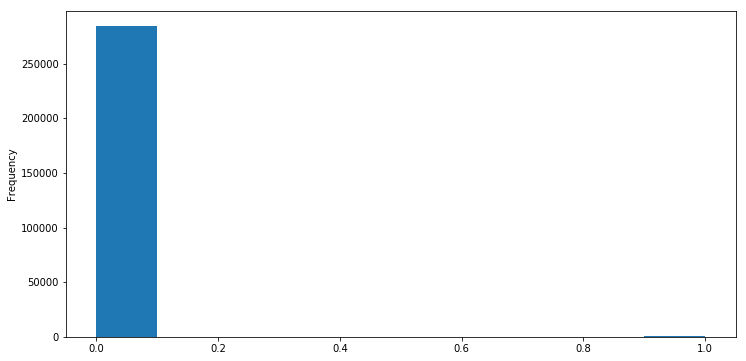

In [30]:
dataset[target].plot.hist()

In [8]:
def corr_pairs(df, gamma=0.99999):
    corr_matrix = df.corr().abs()
    os = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
          .stack()
          .sort_values(ascending=False))
    return os[os>gamma].index.values.tolist()

In [4]:
target = 'Class'
predictors = [x for x in dataset.columns if x not in [target]]

In [86]:
cpair = corr_pairs(dataset[predictors])
cpair

[]

In [87]:
len(cpair)

0

In [18]:
rate = dataset[target].values.sum()/dataset.shape[0]
rate

0.001727485630620034

In [ ]:
def glimpse(data, target):
    print('\nInformation:')
    print(data.info())
    print('\nHead:')
    print(data.head())
    print('\nShape:')
    print(data.shape)
    print('\nTarget Rate:')
    print(dataset[target].values.sum()/dataset.shape[0])
    print('\nCorrelated Predictors(0.9999):')
    print(corr_pairs(dataset[predictors], gamma = 0.9999))
    print('\nCorrelated Predictors(0.9):')
    print(corr_pairs(dataset[predictors], gamma = 0.9))
    print('\nCorrelated Predictors(0.85):')
    print(corr_pairs(dataset[predictors], gamma = 0.85))
    print('\nTarget Distribution:')
    data[target].plot.hist(bins=2)
    return None

In [ ]:
glimpse(dataset, 'Class')

## ML

In [5]:
seed = 2018
dtrain, dtest = train_test_split(dataset, test_size=0.2, random_state=seed)

In [25]:
def simAnneal(Train, predictors, target, param, results=True):
    print('\nsimulating...')
    gbm = LGBMClassifier(
        learning_rate=0.01, n_estimators=5000, objective='binary', metric='auc', 
        save_binary=True, is_unbalance=True, random_state=2017
    )
    sa = SimulatedAnneal(gbm, param, T=10.0, T_min=0.001, alpha=0.75,
                         verbose=True, max_iter=0.25, n_trans=5, max_runtime=300,
                         cv=3, scoring='roc_auc', refit=True)
    sa.fit(Train[predictors].as_matrix(), Train[target].as_matrix())
    if results:
        print('\n best score: ', sa.best_score_,
              '\n best parameters: ', sa.best_params_)
    optimized_clf = sa.best_estimator_
    return optimized_clf

def report(clf, Train, Test, predictors, target):
    print('\npredicting...')
    dtrain_predictions = clf.predict(Train[predictors])
    dtest_predictions = clf.predict(Test[predictors])
    dtrain_predprob = clf.predict_proba(Train[predictors])[:,1]
    dtest_predprob = clf.predict_proba(Test[predictors])[:,1]
    print("\nModel Report")
    print("Accuracy : %f" % metrics.accuracy_score(Train[target], dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Train[target], dtrain_predprob))
    print('AUC Score (Test): %f' % metrics.roc_auc_score(Test[target], dtest_predprob))
    print(classification_report(Test[target], dtest_predictions))
    return None

In [24]:
param_1 = {
    #     'boosting_type': ['gbdt', 'dart'],
    #     'num_leaves': [i for i in range(3, 20, 1)],
    'max_depth': [i for i in range(1, 10, 1)],
    'subsample': [i / 10.0 for i in range(1, 10, 1)],
    'colsample_bytree': [i / 10.0 for i in range(1, 10, 1)],
}

In [26]:
optimized_clf = simAnneal(dtrain, predictors, target, param = param_1)
report(optimized_clf, dtrain, dtest, predictors, target)


simulating...

INFO: Number of possible iterations given cooling schedule: 160



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min finished


2 T: 10.00000, score: 0.975, std: 0.005, params: {'max_depth': 9, 'subsample': 0.80000000000000004, 'colsample_bytree': 0.59999999999999998}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min finished


3 T: 10.00000, score: 0.962, std: 0.017, params: {'max_depth': 9, 'subsample': 0.20000000000000001, 'colsample_bytree': 0.59999999999999998}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.7min finished


4 T: 10.00000, score: 0.962, std: 0.015, params: {'max_depth': 9, 'subsample': 0.20000000000000001, 'colsample_bytree': 0.80000000000000004}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min finished


5 T: 10.00000, score: 0.961, std: 0.013, params: {'max_depth': 8, 'subsample': 0.20000000000000001, 'colsample_bytree': 0.80000000000000004}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min finished


6 T: 10.00000, score: 0.968, std: 0.009, params: {'max_depth': 8, 'subsample': 0.29999999999999999, 'colsample_bytree': 0.80000000000000004}

 best score:  0.974578070236 
 best parameters:  {'max_depth': 9, 'subsample': 0.80000000000000004, 'colsample_bytree': 0.59999999999999998}

predicting...

Model Report
Accuracy : 1.000000
AUC Score (Train): 1.000000
AUC Score (Test): 0.988837
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     93824
          1       0.93      0.83      0.88       163

avg / total       1.00      1.00      1.00     93987



In [43]:
param_2 = {
    #     'boosting_type': ['gbdt', 'dart'],
    #     'num_leaves': [i for i in range(3, 20, 1)],
    'max_depth': [i for i in range(8, 12, 1)],
    'subsample': [i / 100.0 for i in range(75, 85, 1)],
    'colsample_bytree': [i / 100.0 for i in range(55, 65, 1)],
}
optimized_clf = simAnneal(dtrain, predictors, target, param = param_2)
report(optimized_clf, dtrain, dtest, predictors, target)


simulating...

INFO: Number of possible iterations given cooling schedule: 160



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 101.5min finished


2 T: 10.00000, score: 0.976, std: 0.003, params: {'max_depth': 10, 'subsample': 0.82999999999999996, 'colsample_bytree': 0.63}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min finished


3 T: 10.00000, score: 0.976, std: 0.004, params: {'max_depth': 9, 'subsample': 0.82999999999999996, 'colsample_bytree': 0.63}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min finished


4 T: 10.00000, score: 0.976, std: 0.003, params: {'max_depth': 11, 'subsample': 0.82999999999999996, 'colsample_bytree': 0.63}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min finished


5 T: 10.00000, score: 0.974, std: 0.005, params: {'max_depth': 11, 'subsample': 0.76000000000000001, 'colsample_bytree': 0.63}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min finished


6 T: 10.00000, score: 0.974, std: 0.004, params: {'max_depth': 11, 'subsample': 0.76000000000000001, 'colsample_bytree': 0.57999999999999996}

 best score:  0.976234064836 
 best parameters:  {'max_depth': 10, 'subsample': 0.82999999999999996, 'colsample_bytree': 0.63}

predicting...

Model Report
Accuracy : 1.000000
AUC Score (Train): 1.000000
AUC Score (Test): 0.988917
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     93824
          1       0.92      0.82      0.87       163

avg / total       1.00      1.00      1.00     93987



## Area Under the Precision-Recall Curve

In [47]:
import itertools

def plot_confusion_matrix(cm, classes = [0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

def report_CM(clf, Test, predictors, target):
    print('\npredicting...')
    dtest_predictions = clf.predict(Test[predictors])
    print("\nModel Report")
    cnf_matrix = confusion_matrix(Test[target], dtest_predictions)
    np.set_printoptions(precision=2)
    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    plt.figure()
    plot_confusion_matrix(cnf_matrix)
    return None


predicting...

Model Report
Recall metric in the testing dataset:  0.822085889571


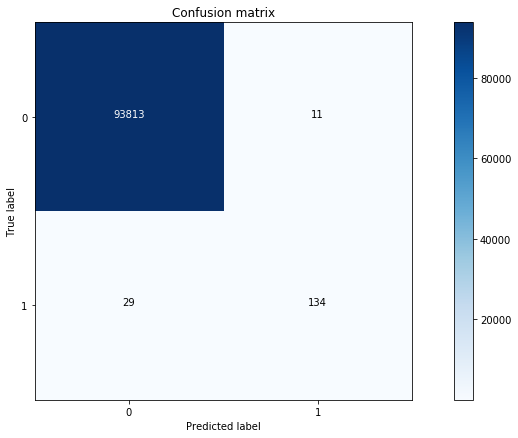

In [49]:
report_CM(optimized_clf, dtest, predictors, target)

Recall metric in the testing dataset:  0.840490797546
Recall metric in the testing dataset:  0.840490797546
Recall metric in the testing dataset:  0.834355828221
Recall metric in the testing dataset:  0.828220858896
Recall metric in the testing dataset:  0.822085889571
Recall metric in the testing dataset:  0.815950920245
Recall metric in the testing dataset:  0.815950920245
Recall metric in the testing dataset:  0.815950920245
Recall metric in the testing dataset:  0.815950920245


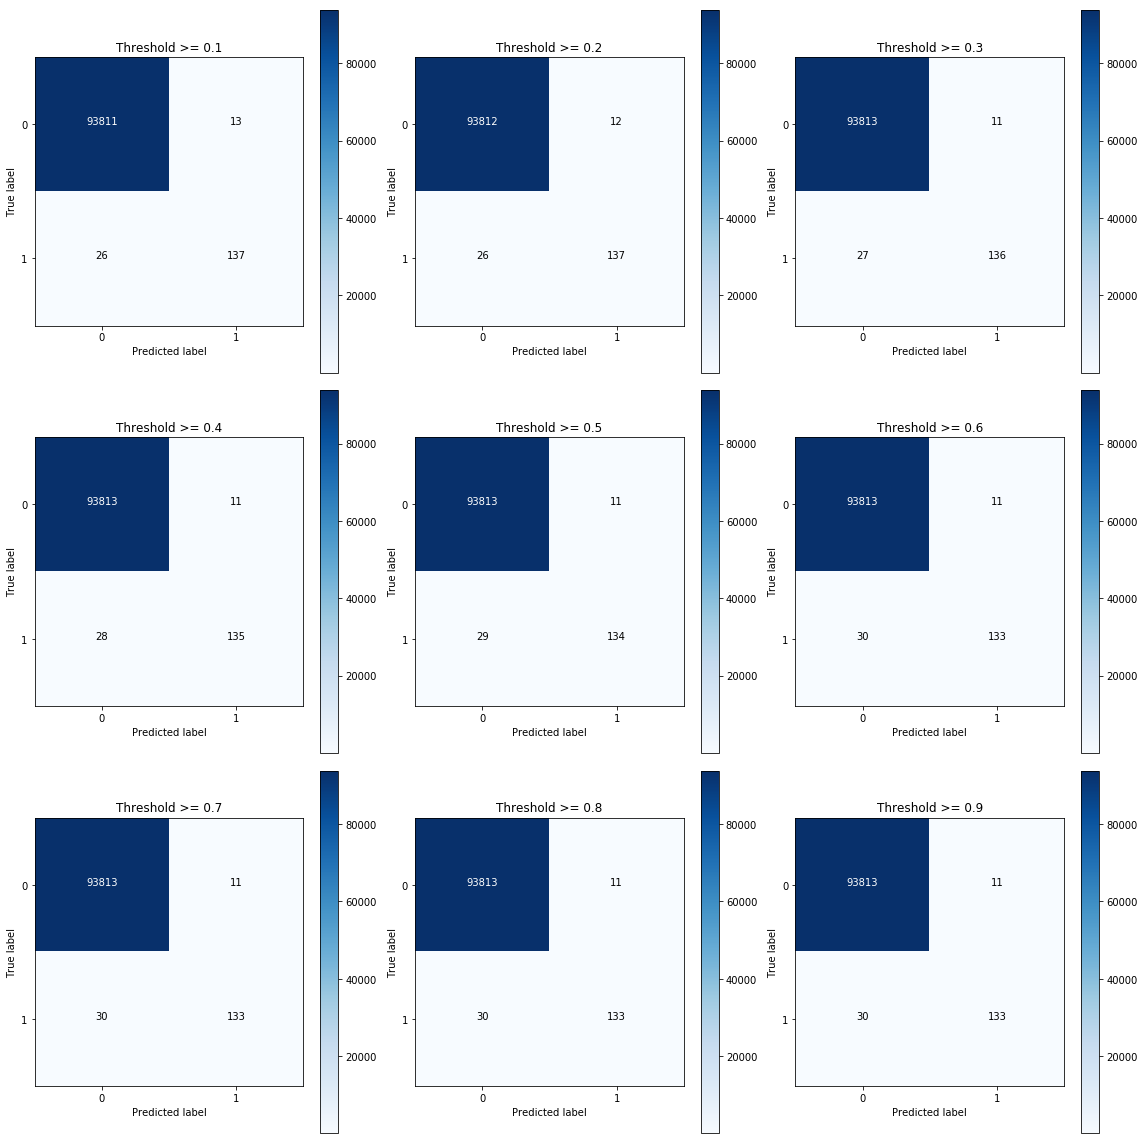

In [66]:
dtest_predprob = optimized_clf.predict_proba(dtest[predictors])

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(16, 16))

j = 1
for i in thresholds:
    dtest_pred = (dtest_predprob[:, 1] > i).astype(int)
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(dtest[target], dtest_pred)
    np.set_printoptions(precision=2)
    
    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, title='Threshold >= %s'%i) 

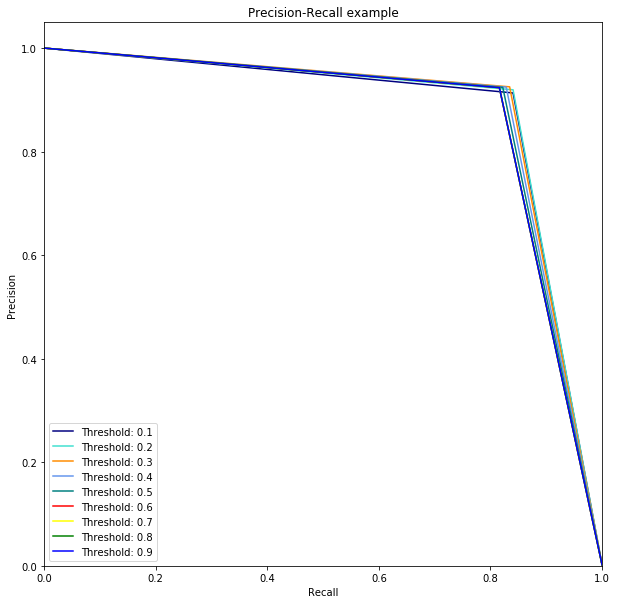

In [71]:
from itertools import cycle

dtest_predprob = optimized_clf.predict_proba(dtest[predictors])

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10, 10))

j = 1
for i, color in zip(thresholds, colors):
    dtest_pred = (dtest_predprob[:, 1] > i).astype(int)
    
    precision, recall, thresholds = precision_recall_curve(dtest[target], dtest_pred)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color, label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

Text(0.5,1,'Precision-Recall curve: AP=0.87')

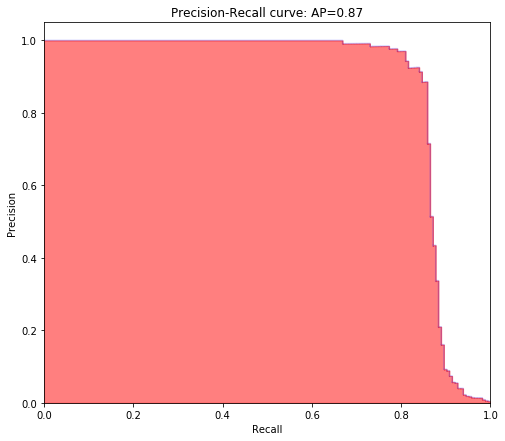

In [81]:
# from sklearn.metrics import average_precision_score
# dtest_predprob = optimized_clf.predict_proba(dtest[predictors])[:, 1]

# precision, recall, _ = precision_recall_curve(dtest[target], dtest_predprob)

# average_precision = average_precision_score(dtest[target], dtest_predprob)

plt.figure(figsize=(8, 7))

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='red')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [84]:
def report_PR(clf, Test, predictors, target):
    print('\npredicting...')
    dtest_predprob = clf.predict_proba(Test[predictors])[:, 1]
    precision, recall, _ = precision_recall_curve(Test[target], dtest_predprob)
    average_precision = average_precision_score(Test[target], dtest_predprob)
    print('\nModel Report')
    print('Average Precision: {0:0.4f}'.format(average_precision))
    plt.figure(figsize=(8, 7))

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='red')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    return None


predicting...

Model Report
Average Precision: 0.8707


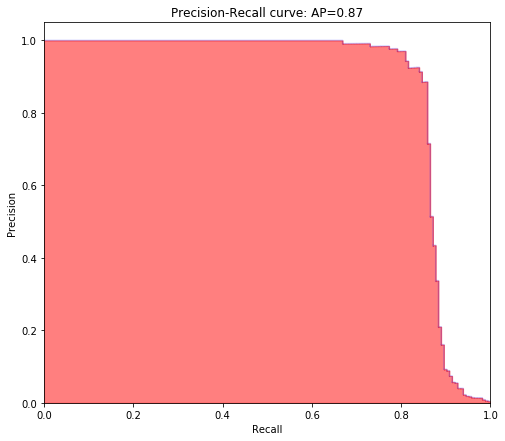

In [85]:
report_PR(optimized_clf, dtest, predictors, target)

### Baseline Test

In [6]:
import Baseline as bs

In [7]:
base = bs.Baseline(dtrain, dtest, target, predictors)


predicting...

done.

Model Report
Accuracy : 0.999109
ROC AUC Score (train): 0.813650
ROC AUC Score (test): 0.809912
PR AUC Score (train): 0.510138
PR AUC Score (test): 0.534556
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56862
        1.0       0.86      0.62      0.72       100

avg / total       1.00      1.00      1.00     56962


Model Report
Recall metric in the testing dataset:  0.62


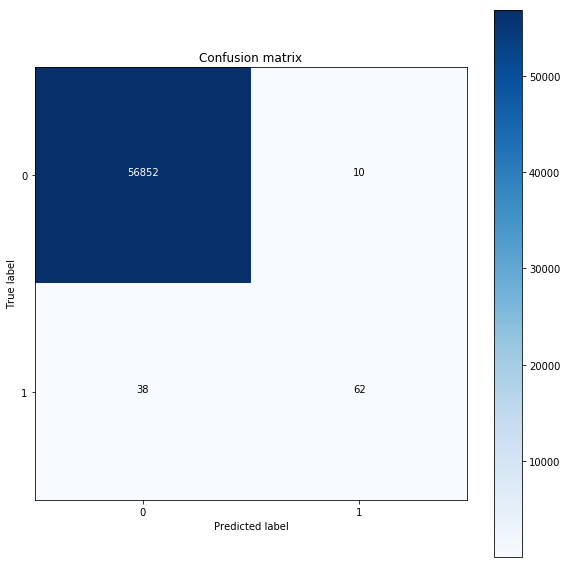

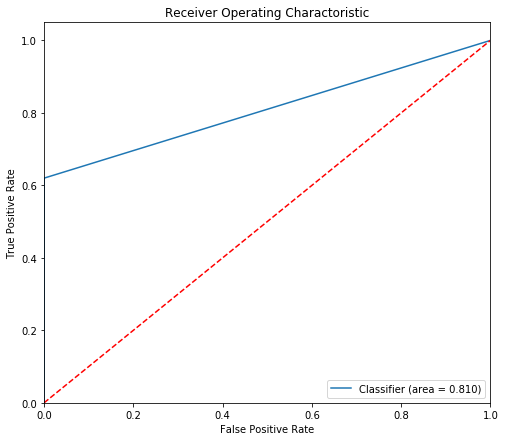


Model Report
Average Precision: 0.535


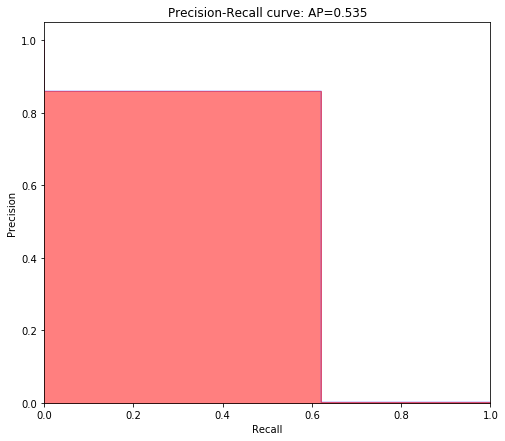

In [8]:
lr = base.LR(report=True)


predicting...

done.

Model Report
Accuracy : 0.999732
ROC AUC Score (train): 0.922194
ROC AUC Score (test): 0.884956
PR AUC Score (train): 0.844655
PR AUC Score (test): 0.723453
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     56862
        1.0       0.94      0.77      0.85       100

avg / total       1.00      1.00      1.00     56962


Model Report
Recall metric in the testing dataset:  0.77


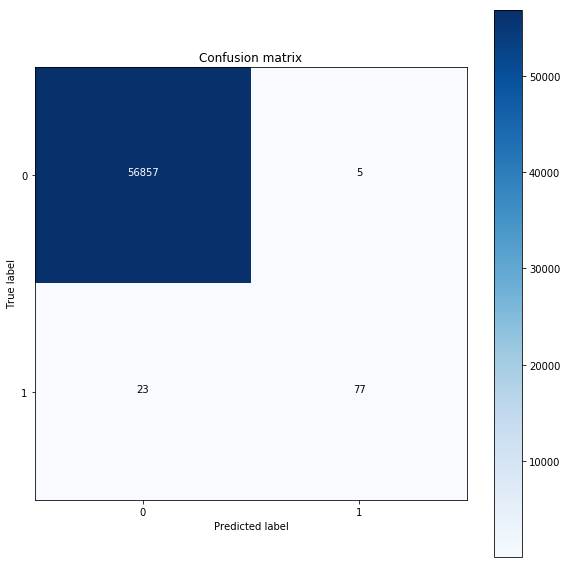

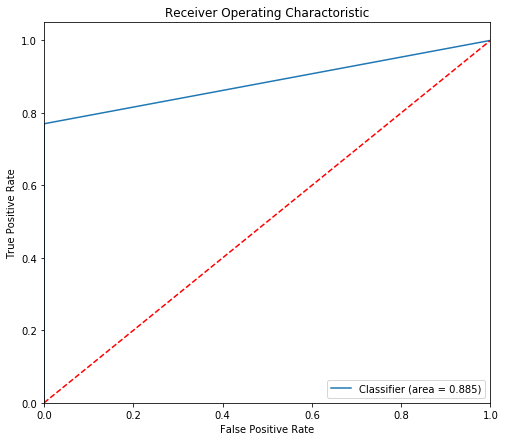


Model Report
Average Precision: 0.723


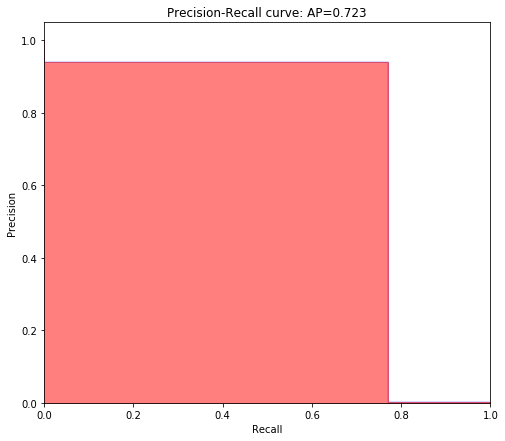

In [9]:
rf = base.RF(report=True)


predicting...

done.

Model Report
Accuracy : 1.000000
ROC AUC Score (train): 1.000000
ROC AUC Score (test): 0.889965
PR AUC Score (train): 1.000000
PR AUC Score (test): 0.742337
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56862
          1       0.95      0.78      0.86       100

avg / total       1.00      1.00      1.00     56962


Model Report
Recall metric in the testing dataset:  0.78


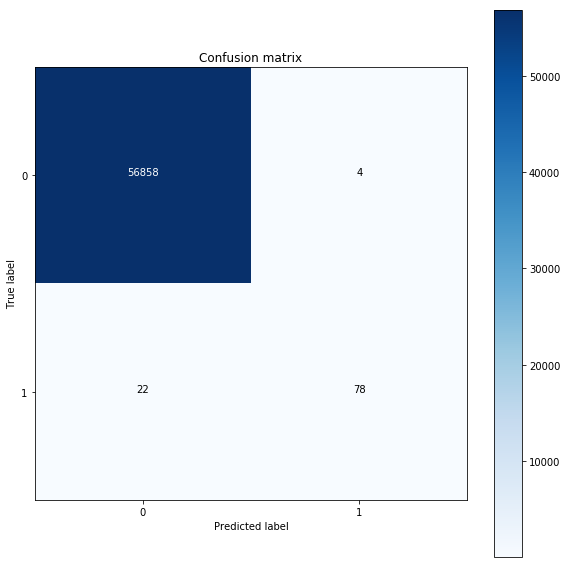

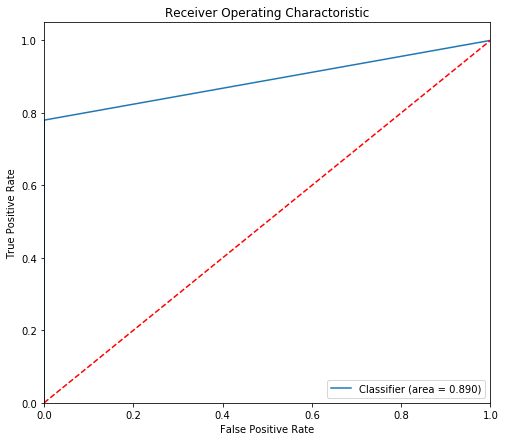


Model Report
Average Precision: 0.742


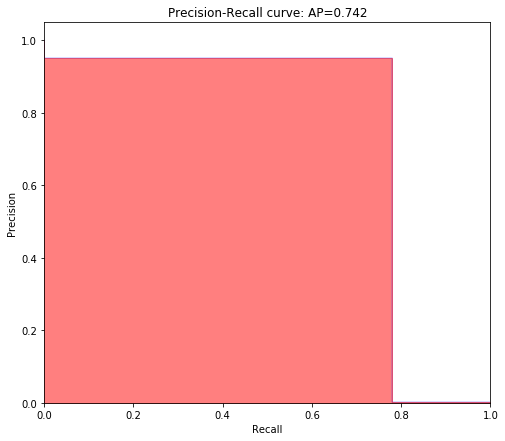

In [10]:
gb = base.GBDT(report=True)

Using TensorFlow backend.


Epoch 1/5
227845/227845 [==============================] - 68s 298us/step - loss: 0.0277 - acc: 0.9983
Epoch 2/5
227845/227845 [==============================] - 65s 287us/step - loss: 0.0277 - acc: 0.9983
Epoch 3/5
227845/227845 [==============================] - 62s 271us/step - loss: 0.0277 - acc: 0.9983
Epoch 4/5
227845/227845 [==============================] - 64s 279us/step - loss: 0.0277 - acc: 0.9983
Epoch 5/5
227845/227845 [==============================] - 63s 275us/step - loss: 0.0277 - acc: 0.99830s - loss: 0.0278 - acc: 0.9

predicting...
56962/56962 [==============================] - 7s 115us/step

done.

Model Report
Accuracy : 0.998280
ROC AUC Score (train): 0.500000
ROC AUC Score (test): 0.500000
PR AUC Score (train): 0.001720
PR AUC Score (test): 0.001756
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56862
          1       0.00      0.00      0.00       100

avg / total       1.00      1.00      1.00     56962




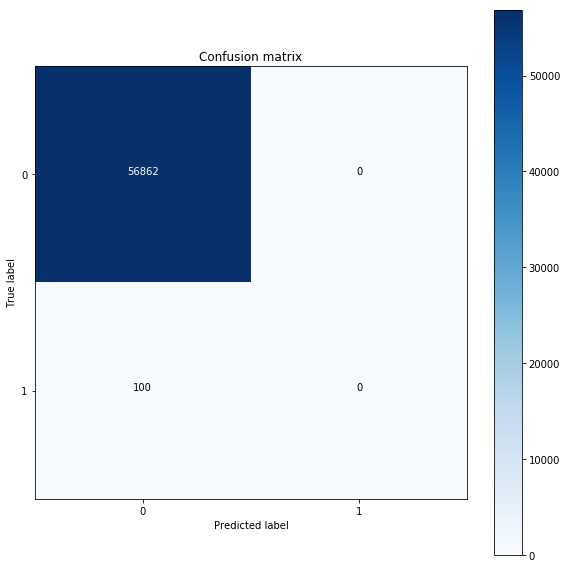

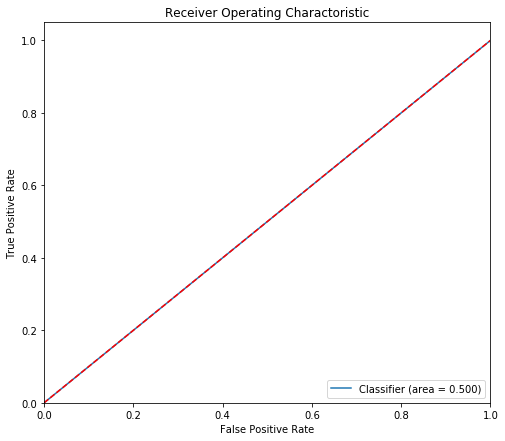


Model Report
Average Precision: 0.002


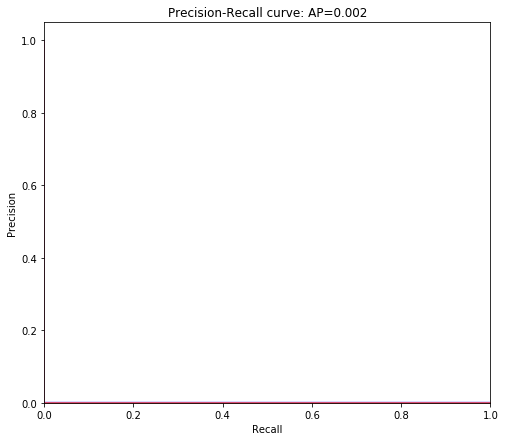

In [11]:
nn = base.NN(report=True)